# 1. Taking a look at our dataset

for convenience we've made some helping tools:
- a function to download / initialize the data
- a function to enhance the data
- a class that handles the dataset functionality

## Downloading / initializing the data

In [ ]:
import multiprocessing as mlp
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
os.environ['KAGGLE_USERNAME'] = 'dumpstertrash'
os.environ['KAGGLE_KEY'] = 'fc29a78761d58a50c7b50d71f3f3a3f2'
from kaggle.api.kaggle_api_extended import KaggleApi
from lib.xray.clahe import CLAHE


def initialize_dataset():
    names = ["COVID", "Normal", "Viral Pneumonia"]
    print("Downloading...")
    api = KaggleApi()
    # env vars are set (see top of this file)
    api.authenticate()
    api.dataset_download_files('tawsifurrahman/covid19-radiography-database', path="./dataset")
    print("Unzipping...")
    with zipfile.ZipFile(f"./dataset/covid19-radiography-database.zip","r") as zip_ref:
        zip_ref.extractall(f"./dataset/")
    os.remove("./dataset/covid19-radiography-database.zip")
        
    print(f"Setting up the directory structure...")
    for name in names:
        os.mkdir(f"dataset/{name}")
        for version in ["images", "masks"]:
            os.mkdir(f"dataset/{name}/{version}")
            file_list = [f"{file}" for file in os.listdir(f"./dataset/COVID-19_Radiography_Dataset/{name}/{version}")]
            file_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

            file_list = file_list[:1345] # take first 1345 files
            
            for file in file_list:
                try:
                    os.rename(f"./dataset/COVID-19_Radiography_Dataset/{name}/{version}/{file}", f"./dataset/{name}/{version}/{file}")
                except:
                    print("Error while moving file : ", file)
    print("Removing the old database")
    shutil.rmtree("./dataset/COVID-19_Radiography_Dataset")
    
    print(f"Converting size of the images and masks to 244x244x3")
    for name in names:
        for file in os.listdir(f"./dataset/{name}/images"):
            img_path = f"./dataset/{name}/images/{file}"
            mask_path = f"./dataset/{name}/masks/{file}"

            image = plt.imread(img_path)

            # Some images are not 8 bit, so we convert them
            if (len(image.shape) != 2):
                img = Image.open(img_path)
                new_img = img.convert("L")
                new_img.save(img_path)

            # Convert image to 224,224,3
            img = Image.open(f"./dataset/{name}/images/{file}")
            new_img = img.convert("RGB")
            new_img = new_img.resize(size=(224, 224))
            new_img.save(img_path)

            # Convert mask to 224,224,3
            msk = Image.open(mask_path)
            new_msk = msk.resize(size=(224, 224))
            new_msk.save(mask_path)

    print("Applying the masks on the images...")
    X = np.zeros((1345*3, 224, 224, 3), dtype=np.float32)
    index = 0
    for name in names:
        for file in os.listdir(f"./dataset/{name}/images"):
            img = Image.open(f"./dataset/{name}/images/{file}") # Reads in uint8

            # change grey to rgb
            if img.mode == "L":
                img = img.convert("RGB")
            
            new_img = np.array(img).astype(np.float32)
            new_img /= 255
                
            np_image = np.array(new_img)
            np_mask = plt.imread(f"./dataset/{name}/masks/{file}") # Reads in float32
            # Apply the mask
            new_image = np.multiply(np_image, np_mask)
            # save to array
            X[index] = new_image
            index += 1
    print("Gathering the labels...")
    y = np.concatenate([np.array([name] * len(os.listdir(f"./dataset/{name}/images"))) for name in names])
    def from_label(x:str):
        return names.index(x)
    y = np.array(list(map(from_label, y))) # map labels to ints of labels

    print(f"Saving the preprocessed dataset...")
    np.save(f"./dataset/x.npy", X)
    np.save(f"./dataset/y.npy", y)
    



## Enhancing the data

In [2]:
import multiprocessing as mlp
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
os.environ['KAGGLE_USERNAME'] = 'dumpstertrash'
os.environ['KAGGLE_KEY'] = 'fc29a78761d58a50c7b50d71f3f3a3f2'
from kaggle.api.kaggle_api_extended import KaggleApi
from lib.xray.clahe import CLAHE

# helper function
def enhance(files, name):
    for file in files:
        CLAHE(f"./dataset/{name}/images/{file}", f"./enhanced/{name}/images", 100, 150, 1).run()

# function that enhances the dataset
def enhance_dataset():
    names = ["COVID", "Normal", "Viral Pneumonia"]
    processes = []
    cores = (mlp.cpu_count() - 2) // 3
    print(f"Using {cores * 3} cores to enhance images")
    
    os.mkdir("./enhanced")

    for name in names:
        print(f"Enhancing: {name}")
        os.mkdir(f"./enhanced/{name}")
        os.mkdir(f"./enhanced/{name}/images")
        shutil.copytree(f"./dataset/{name}/masks", f"./enhanced/{name}/masks")
        for files in np.array_split(os.listdir(f"./dataset/{name}/images"), cores):
            p = mlp.Process(target=enhance, args=(files, name))
            p.start()
            processes.append(p)

    print(f"Made a total of {len(processes)} processes to enhance images")
    for process in processes:
        process.join()
        
    print(f"Converting size of the images and masks to 244x244x3")
    for name in names:
        for file in os.listdir(f"./enhanced/{name}/images"):
            img_path = f"./enhanced/{name}/images/{file}"
            mask_path = f"./enhanced/{name}/masks/{file}"

            image = plt.imread(img_path)

            # Some images are not 8 bit, so we convert them
            if (len(image.shape) != 2):
                img = Image.open(img_path)
                new_img = img.convert("L")
                new_img.save(img_path)
                
            # Convert image to 224,224,3
            img = Image.open(img_path)
            new_img = img.convert("RGB")
            new_img = new_img.resize(size=(224, 224))
            new_img.save(img_path)
            
            # Convert mask to 224,224,3
            msk = Image.open(mask_path)
            new_msk = msk.resize(size=(224, 224))
            new_msk.save(mask_path)

    print("Applying the masks on the images...")
    X = np.zeros((1345*3, 224, 224, 3), dtype=np.float32)
    index = 0
    for name in names:
        for file in os.listdir(f"./enhanced/{name}/images"):
            img = Image.open(f"./enhanced/{name}/images/{file}")

            # change grey to rgb
            if img.mode == "L":
                img = img.convert("RGB")
            
            new_img = np.array(img).astype(np.float32)
            new_img /= 255
                
            np_image = np.array(new_img)
            np_mask = plt.imread(f"./enhanced/{name}/masks/{file}") # Reads in float32
            # Apply the mask
            new_image = np.multiply(np_image, np_mask)
            # save to array
            X[index] = new_image
            index += 1
    print("Gathering the labels...")
    y = np.concatenate([np.array([name] * len(os.listdir(f"./enhanced/{name}/images"))) for name in names])
    def from_label(x:str):
        return names.index(x)
    y = np.array(list(map(from_label, y))) # map labels to ints of labels
    
    print(f"Saving the preprocessed dataset...")
    np.save(f"./enhanced/x.npy", X)
    np.save(f"./enhanced/y.npy", y)

## Dataset functionality class

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

class Dataset():
    def __init__(self, path):
        self.path = path
        self.versions = ["images", "masks"]
        self.class_length = 1345
        self.data = {}
        self.size = 0
        self.names = ["COVID", "Normal", "Viral Pneumonia"]
        self.X = None
        self.y = None
        
    def load_local(self):
        self.X = np.load(f"{self.path}/x.npy")
        self.y = np.load(f"{self.path}/y.npy")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, 
            self.y, 
            train_size=0.85, 
            shuffle=True,
            random_state=42
        )
        self.size = self.X_train.shape[0]
        return self
        
    def split(self):
        return self.X_train, self.X_test, self.y_train, self.y_test

    def to_label(self, x:int):
        return self.names[x]
    
    def from_label(self, x:str):
        return self.names.index()
    
    def to_classlist(self, x:int):
        l = [0.0, 0.0, 0.0]
        l[x] = 1.0
        return l
    
    def from_classlist(self, x):
        return np.argmax(x)          

    def show_image(self, i):
        print(f"Example image with label {self.to_label(self.y[i])}:")
        plt.imshow(self.X[i])

## Taking a look at our dataset

In [6]:
# run the code below if you want to initialize the dataset
#initialize_dataset()

In [8]:
# run the code below if you want to enhance the dataset
# enhance_dataset()

In [80]:
# the dataset
dataset_original = Dataset(path="dataset")
# load the images from the local dataset/x.npy and dataset/y.npy files
dataset_original.load_local()

In [81]:
# the enhanced dataset
dataset_enhanced = Dataset(path="enhanced")
# load the images from the local enhanced/x.npy and enhanced/y.npy files
dataset_enhanced.load_local()

### What's the difference between the original and the enhanced dataset?

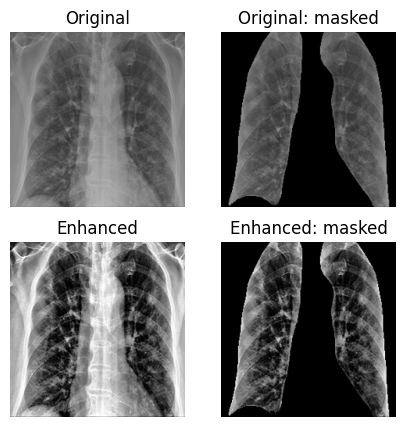

In [82]:
index = 26     # starts from 1, index 26 we have some big lungs

img_original = plt.imread(f"dataset/COVID/images/COVID-{index}.png")
img_original_masked = np.multiply(img_original, plt.imread(f"dataset/COVID/masks/COVID-{index}.png"))

img_enhanced = plt.imread(f"enhanced/COVID/images/COVID-{index}.png")
img_enhanced_masked = np.multiply(img_enhanced, plt.imread(f"enhanced/COVID/masks/COVID-{index}.png"))

images = [
    [img_original, img_original_masked], 
    [img_enhanced, img_enhanced_masked]
]

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

for row, imgtype, imagerow in zip(axes, ["Original", "Enhanced"], images):
    for subplt, imgsubtype, image in zip(row, ["", ": masked"], imagerow):
        subplt.set_axis_off()
        subplt.imshow(image)
        subplt.set_title(f"{imgtype}{imgsubtype}")


So inside our `dataset_original` we have images looking like the top right example, and inside our `dataset_enhanced` we have images looking like the bottom right example

# 2. Classes & functions used for the active learning process

## The Model

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy


class Model():
    def __init__(self, epochs, batch_size):
        self.model = VGG16(include_top=True, weights=None, classes=3)
        self.model.compile(optimizer=Adam(learning_rate=0.0001), loss=categorical_crossentropy, metrics=['accuracy'])
        self.acc = 0
        self.used = [0, 0, 0]
        self.predictions = None
        self.epochs = epochs
        self.batch_size = batch_size
        
    def __str__(self):
        return repr(self)

    def __repr__(self):
        return f"<|AL|epochs|{self.epochs}|batch_size|{self.batch_size}|used|{sum(self.used)}|{self.used}|acc|{self.acc}|>"

    def traintest(self, X_train, y_train, X_test, y_test):
        # count labels used
        for x in y_train:
            self.used[x] += 1
        # fit the model
        self.model.fit(
            x=X_train,
            y=np.array(list(map(dataset.to_classlist, y_train))), 
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )
        # test 
        self.predictions = np.array(list(map(dataset.from_classlist, self.model.predict(X_test, verbose=0))))
        # calc acc
        count = 0
        for i in range(self.predictions.shape[0]):
            if self.predictions[i] == y_test[i]:
                count += 1
        self.acc = count / self.predictions.shape[0]

## The query strategies

In [2]:
# the query strategies to try
import numpy as np


def random(model, X_pool, query_size):
    query_size = min(query_size, X_pool.shape[0])
    # select random indexes
    idxs = np.random.choice(X_pool.shape[0], query_size, replace=False)
    return idxs


def uncertainty(model, X_pool, query_size):
    query_size = min(query_size, X_pool.shape[0])
    # get predictions on remaining training data
    p_pool = model.predict(X_pool)
    # get indexes of most uncertain predictions) (if the max is low, then the prediction is uncertain)
    idxs = np.max(p_pool, axis=1).argsort()[:query_size]
    return idxs


def margin(model, X_pool, query_size):
    query_size = min(query_size, X_pool.shape[0])
    # get predictions on remaining training data
    p_pool = model.predict(X_pool)
    # get indexes of predictions with smallest margin (difference) between first and second most likely
    p_pool.sort(axis=1)
    idxs = np.array([(xi[-1] - xi[-2]) for xi in p_pool]).argsort()[:query_size]
    return idxs


def entropy(model, X_pool, query_size):
    query_size = min(query_size, X_pool.shape[0])
    # get predictions on remaining training data
    p_pool = model.predict(X_pool)
    # get indexes of predictions with highest entropy (-Sum(y):P(y)*log2(P(y))) (last indices have high entr.)
    idxs = -np.sum(np.multiply(p_pool, np.log2(p_pool)), axis=1).argsort()[-query_size:]
    return idxs

qss = [("random", random), ("uncertainty", uncertainty), ("margin", margin), ("entropy", entropy)]

## The Data class

this class handles the labeling of data, and moving data from the unlabeled pool to the labeled training data

In [3]:
import numpy as np

class Data():
    def __init__(self, dataset):
        self.X_test = dataset.X_test
        self.y_test = dataset.y_test
        
        self.X_pool = dataset.X_train
        self.y_pool = dataset.y_train
        
        # empty training pool to start
        s = self.X_pool.shape
        self.X_train = np.empty((0, *s[1:]))
        self.y_train = np.empty((0), dtype=int)
    
    def select(self, qs, n, model):
        # select n images according to the query-strategy qs
        idxs = qs(model, self.X_pool, n)
        # move the selected images to the training set
        self.X_train = np.append(self.X_train, self.X_pool[idxs], axis=0)
        self.y_train = np.append(self.y_train, self.y_pool[idxs], axis=0)
        # remove the selected images from the pool
        self.X_pool = np.delete(self.X_pool, idxs, axis=0)
        self.y_pool = np.delete(self.y_pool, idxs, axis=0)


# 3. Experiments

some helper functions to make directories / files for storing our results

## Initial setup for every experiment

In [4]:
# helper functions for checking if directories/files exist, and if not, to create them
import os

def checkmake_dir(path:str):
    if not os.path.exists(path):
        os.mkdir(path)

def checkmake_file(path:str):
    if not os.path.exists(path):
            with open(path, "w+") as f:
                f.write("")

In [5]:
# variables for colored output
OKCYAN = '\033[96m'
ENDC = '\033[0m'

first, we put our datasets in a list

In [8]:
datasets = [
    Dataset(path="dataset").load_local(), 
    Dataset(path="enhanced").load_local()
]

next we put our query-strategies, together with their name, in a list

In [9]:
qss = [
    ("random", random), 
    ("uncertainty", uncertainty), 
    ("margin", margin), 
    ("entropy", entropy)
]

a "query strategy" that selects the initial training data

In [10]:
def select_first(model, X_pool, query_size):
    query_size = min(query_size, X_pool.shape[0])
    # select first indexes
    return [x for x in range(query_size)]

## 3.1. Comparison of datasets and query strategies

we'll store our results in the "./results_al" directory

In [22]:
resdir = "results_al"
checkmake_dir(resdir)

for this experiment we've chosen a query_size of 32 

max_train_imgs is only here for limiting the duration of this loop, it defines the length of the x-axis in the results

In [12]:
query_size = 16
max_train_imgs = 512

epochs = 16
batch_size = 16

In [13]:
# the steps we will take (steps over the size of the data)
steps = [i for i in range(query_size, max_train_imgs+1, query_size)]
len(steps)

32

In [ ]:
import time 
from datetime import datetime

for dataset in datasets:
    for (name, qs) in qss:
        # initialize the pool of unlabeled data and the empty training set
        data = Data(dataset)
        
        # initial loop iteration, here we select the first query_size samples as initial
        #    training data, because there isn't a model yet
        
        print(f"{OKCYAN}Starting '{name}' with {query_size} images (1/{len(steps)}){ENDC} (Current Time: {datetime.now().strftime('%H:%M:%S')})")
        time_start = time.time()
        # initial training data  (model not important here)
        data.select(select_first, query_size, None)
        # get a model
        model = Model(epochs, batch_size)
        # train & test the model
        model.traintest(data.X_train, data.y_train, data.X_test, data.y_test)
        # save the stats of the model
        checkmake_dir(f"{resdir}/{dataset.path}")
        checkmake_dir(f"{resdir}/{dataset.path}/{name}")
        checkmake_file(f"{resdir}/{dataset.path}/{name}/checkpoints.txt")
        with open(f"{resdir}/{dataset.path}/{name}/checkpoints.txt", "a") as f:
                f.write(f"{str(model)}\n")
        # print some feedback
        time_total = int(time.time() - time_start) // 60
        print(f"----> finished '{name}' with {query_size} images in {time_total} mins")
        
        # the active-learning loop
        for j, max_imgs in enumerate(steps[1:]):  # skip the first step, as we already did that
            print(f"{OKCYAN}Starting '{name}' with {max_imgs} images ({j+1}/{len(steps)}){ENDC} (Current Time: {datetime.now().strftime('%H:%M:%S')})")
            time_start = time.time()
            # select new samples
            data.select(qs, query_size, model)
            # get a new model
            model = Model(epochs, batch_size)
            # train & test the model
            model.traintest(data.X_train, data.y_train, data.X_test, data.y_test)
            # save the stats of the model
            with open(f"{resdir}/{dataset.path}/{name}/checkpoints.txt", "a") as f:
                    f.write(f"{str(model)}\n")
            # print some feedback
            time_total = int(time.time() - time_start) // 60
            print(f"----> finished '{name}' with {max_imgs} images in {time_total} mins")

Starting 'random' with 16 images (1/32) (Current Time: 14:59:27)
----> finished 'random' with 16 images in 0 mins
Starting 'random' with 32 images (1/32) (Current Time: 14:59:45)
----> finished 'random' with 32 images in 0 mins
Starting 'random' with 48 images (2/32) (Current Time: 15:00:15)
----> finished 'random' with 48 images in 0 mins
Starting 'random' with 64 images (3/32) (Current Time: 15:00:58)
----> finished 'random' with 64 images in 0 mins
Starting 'random' with 80 images (4/32) (Current Time: 15:01:49)
----> finished 'random' with 80 images in 1 mins
Starting 'random' with 96 images (5/32) (Current Time: 15:02:50)
----> finished 'random' with 96 images in 1 mins
Starting 'random' with 112 images (6/32) (Current Time: 15:04:01)
----> finished 'random' with 112 images in 1 mins
Starting 'random' with 128 images (7/32) (Current Time: 15:05:26)
----> finished 'random' with 128 images in 1 mins
Starting 'random' with 144 images (8/32) (Current Time: 15:07:03)
----> finished 'ra

## 3.2 grid-search for epochs and batch_size in every iteration